# ACS2 in Multiplexer

In [1]:
%matplotlib inline

# General
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Logger
import logging
logging.basicConfig(level=logging.WARN)

# ALCS + custom environments
import sys
sys.path.append('/Users/khozzy/Projects/pyalcs')
sys.path.append("/Users/khozzy/Projects/openai-envs")

# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# Load PyALCS module
from alcs import ACS2, ACS2Configuration

# Load environments
import gym
import gym_multiplexer

## Multiplexer

In [2]:
mp = gym.make('boolean-multiplexer-6bit-v0')
situation = mp.reset()
mp.render()

'1000010'

In [3]:
state, reward, done, _ = mp.step(0)

print("New state: {}, reward: {}, is done: {}".format(state, reward, done))

New state: 1000011, reward: 1000, is done: True


In [4]:
mp.render()

'1000011'

### Evaluation
Calculate knowledge - check if any of the reliable classifiers gives correct answer.

In [7]:
from gym_multiplexer.utils import get_correct_answer

def evaluate_performance(env, population, ctrl_bits):
    p1 = env.render()  # state after executing action
    p0 = p1[:-1] + '0'  # initial state
    true_action = get_correct_answer(p0, ctrl_bits)
    
    # get all classifiers matching initial state
    matching_cls = {c for c in population if c.condition.does_match(p0)}
    best_cl = max(matching_cls, key=lambda cl: cl.q)
        
    return {'was_correct': best_cl.predicts_successfully(p0, true_action, p1)}

## Go agent, go...
Perform experiment for a couple of explore/exploit trials.

In [20]:
def get_6bit_mp_actors():
    mp = gym.make('boolean-multiplexer-6bit-v0')
    cfg = ACS2Configuration(
    mp.env.observation_space.n,
    2,
    performance_fcn=evaluate_performance,
    performance_fcn_params={'ctrl_bits': 2},
    do_ga=True)

    return ACS2(cfg), mp

def get_11bit_mp_actors():
    mp = gym.make('boolean-multiplexer-11bit-v0')
    cfg = ACS2Configuration(
    mp.env.observation_space.n,
    2,
    performance_fcn=evaluate_performance,
    performance_fcn_params={'ctrl_bits': 3},
    do_ga=True)

    return ACS2(cfg), mp

In [63]:
def perform_experiment(agent, env, trials=50000):
    population, metrics = agent.explore_exploit(env, trials)
    print("Population size: {}".format(metrics[-1]['agent']['population']))
    print("Reliable size: {}".format(metrics[-1]['agent']['reliable']))
    print(metrics[-1])
    
    reliable_classifiers = [c for c in population if c.is_reliable()]
    reliable_classifiers = sorted(reliable_classifiers, key=lambda cl: -cl.q)

    # Print top 20 reliable classifiers
    for cl in reliable_classifiers[:20]:
        print(f"{cl}, q: {cl.q:.2f}, exp: {cl.exp:.2f}")
    
    return population, metrics

In [64]:
# 6bit
p6, m6 = perform_experiment(*get_6bit_mp_actors())

Population size: 77
Reliable size: 22
{'agent': {'population': 77, 'numerosity': 303, 'reliable': 22, 'fitness': 431.68185312265507, 'trial': 49999, 'steps': 1, 'total_steps': 50000}, 'environment': None, 'performance': {'was_correct': True}}
01#0###-1-####### @ 0x1167dce80, q: 1.00, exp: 909.00
11###0#-1-####### @ 0x11726e208, q: 1.00, exp: 856.00
01#1###-1-######1 @ 0x1143210f0, q: 1.00, exp: 2189.00
11###1#-0-####### @ 0x1143213c8, q: 1.00, exp: 868.00
01#1###-0-####### @ 0x1143214e0, q: 1.00, exp: 820.00
11###0#-0-######1 @ 0x1171a5ba8, q: 1.00, exp: 2252.00
001####-1-######1 @ 0x1171a5898, q: 1.00, exp: 2239.00
10##1##-0-####### @ 0x11726e0b8, q: 1.00, exp: 875.00
01#0###-0-######1 @ 0x11726e0f0, q: 1.00, exp: 2207.00
10##0##-1-####### @ 0x1171bcf98, q: 1.00, exp: 865.00
000####-1-####### @ 0x116b318d0, q: 1.00, exp: 830.00
000####-0-######1 @ 0x1171bc160, q: 1.00, exp: 2177.00
10##0##-0-######1 @ 0x113b48438, q: 1.00, exp: 2115.00
10##1##-1-######1 @ 0x1171a5f28, q: 1.00, exp: 21

In [65]:
# 11bit
p11, m11 = perform_experiment(*get_11bit_mp_actors())

Population size: 392
Reliable size: 47
{'agent': {'population': 392, 'numerosity': 823, 'reliable': 47, 'fitness': 341.11354585150605, 'trial': 49999, 'steps': 1, 'total_steps': 50000}, 'environment': None, 'performance': {'was_correct': True}}
1#1#####1#1#-0-############ @ 0x11718ff98, q: 1.00, exp: 469.00
010##0######-0-###########1 @ 0x116e79a90, q: 1.00, exp: 1057.00
100####1####-1-###########1 @ 0x116d036d8, q: 1.00, exp: 1004.00
001#0#######-0-###########1 @ 0x116e57860, q: 1.00, exp: 939.00
011###1#####-1-###########1 @ 0x1171b9470, q: 1.00, exp: 982.00
011###0#####-0-###########1 @ 0x114321080, q: 1.00, exp: 919.00
010##1######-1-###########1 @ 0x116d03e48, q: 1.00, exp: 930.00
110######1##-1-###########1 @ 0x11722cf60, q: 1.00, exp: 909.00
101#####1###-1-###########1 @ 0x11722c828, q: 1.00, exp: 882.00
111#######0#-0-###########1 @ 0x116e6dd30, q: 1.00, exp: 831.00
111#######1#-1-###########1 @ 0x116e6d668, q: 1.00, exp: 819.00
001#1#######-1-###########1 @ 0x1171a7390, q: 1.0

In [66]:
def parse_metrics_to_df(metrics):
    def extract_details(row):
        row['trial'] = row['agent']['trial']
        row['numerosity'] = row['agent']['numerosity']
        row['reliable'] = row['agent']['reliable']
        row['was_correct'] = row['performance']['was_correct']
        return row
    
    df = pd.DataFrame(metrics)
    df = df.apply(extract_details, axis=1)
    df.drop(['agent', 'environment', 'performance'], axis=1, inplace=True)
    df.set_index('trial', inplace=True)
    
    return df

In [67]:
# parse 6bit, 11bit metrics to df
df6bit, df11bit = parse_metrics_to_df(m6), parse_metrics_to_df(m11)

df6bit.head()

,numerosity,reliable,was_correct
trial,,,
0,1,0,True
1,1,0,False
2,1,0,True
3,1,0,True
4,2,0,False


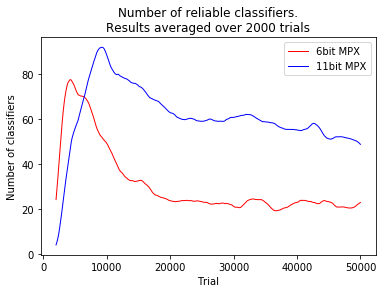

In [76]:
window=2000

df6bit['reliable'].rolling(window=window).mean().plot(color='r', linewidth=1.0, label=f'6bit MPX')
df11bit['reliable'].rolling(window=window).mean().plot(color='b', linewidth=1.0, label=f'11bit MPX')

plt.ylabel('Number of classifiers')
plt.xlabel('Trial')
plt.title(f'Number of reliable classifiers.\nResults averaged over {window} trials')
plt.legend()
#plt.show()

plt.savefig('6bit_11bit_mpx.eps', format='eps', dpi=100)